Baseline estimator combining us_disaster_declarations and weather events us
Events and weather are aggregated at state level

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## Dataset preparation

### Load disaster dataset 

In [104]:
disaster_dataset_path = './datasets/us_disaster_declarations.csv'
di_df = pd.read_csv(disaster_dataset_path)

In [105]:
di_df = di_df.drop(columns=di_df.columns.difference(['state','incident_type','incident_begin_date']))

In [106]:
# valuable_types = [ 'Coastal Storm', 'Drought', 'Fire', 'Freezing', 'Flood', 'Hurricane', 
#                   'Mud/Landslide',  'Severe Ice Storm', 'Snowstorm',  'Severe Storm', 'Tornado', 
#                   'Tropical Storm', 'Tsunami', 'Typhoon', 'Winter Storm']

# keep only storms and hurricanes
valuable_types = ['Flood']
di_df = di_df[di_df['incident_type'].isin(valuable_types)]
# di_df['incident_type'].value_counts().plot(kind='bar', figsize=(12,6))

In [107]:
di_df['incident_begin_date'] = pd.to_datetime(di_df['incident_begin_date'], errors='coerce')
di_df = di_df.dropna(subset=['incident_begin_date'])
print('Min, Max: ', di_df['incident_begin_date'].min(), di_df['incident_begin_date'].max())

Min, Max:  1953-05-29 00:00:00+00:00 2025-08-09 00:00:00+00:00


In [108]:
di_df = di_df[(di_df['incident_begin_date'] > '2016-01-01') & (di_df['incident_begin_date'] < '2022-12-31')]
print('Min, Max: ', di_df['incident_begin_date'].min(), di_df['incident_begin_date'].max())

Min, Max:  2016-03-07 00:00:00+00:00 2022-12-27 00:00:00+00:00


### Load weather dataset

In [109]:
weather_dataset_path = "datasets/WeatherEvents_Jan2016-Dec2022.csv"
we_df = pd.read_csv(weather_dataset_path)
we_df.head()

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


In [110]:
we_df = we_df.drop(columns=we_df.columns.difference(['State','Type', 'Severity', 'StartTime(UTC)']))

In [111]:
we_df['StartTime(UTC)'] = pd.to_datetime(we_df['StartTime(UTC)'], errors='coerce')
we_df = we_df.dropna(subset=['StartTime(UTC)'])
print('Min, Max: ', we_df['StartTime(UTC)'].min(), we_df['StartTime(UTC)'].max())

Min, Max:  2016-01-01 05:00:00 2022-12-31 23:55:00


<Axes: xlabel='Type'>

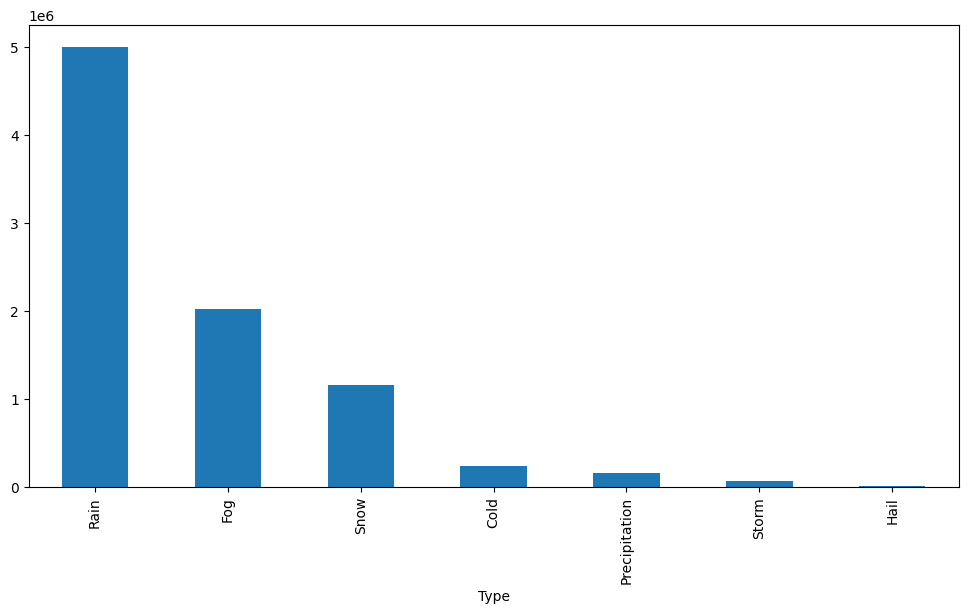

In [112]:
we_df['Type'].value_counts().plot(kind='bar', figsize=(12,6))

In [113]:
we_df.drop(we_df[(we_df['Type'] == 'Fog') | (we_df['Type'] == 'Hail') | (we_df['Type'] == 'Cold')].index, inplace=True)

### Visualize the datasets

C:\Users\matti\AppData\Local\Temp\ipykernel_14212\2801658538.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  di_df['year_month'] = di_df['incident_begin_date'].dt.to_period('M')


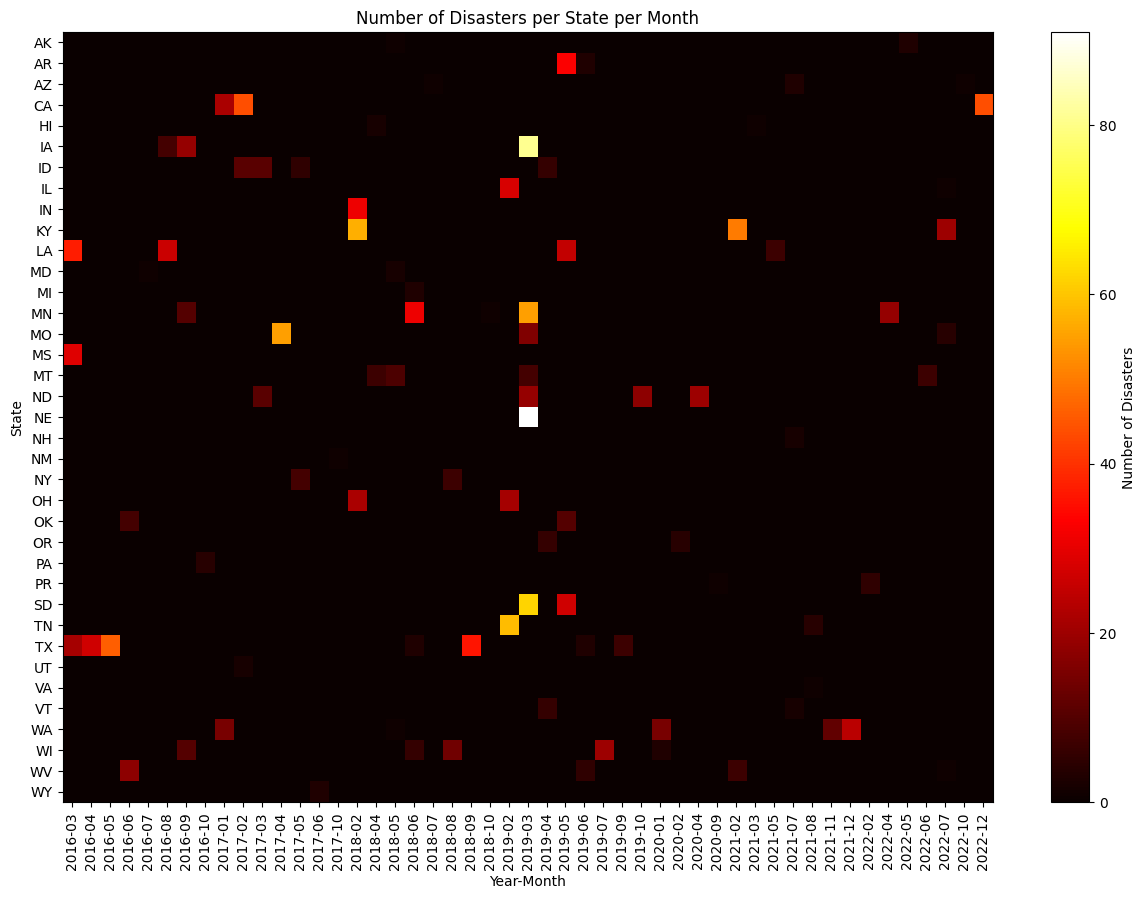

In [114]:
# heatmap with states on the y axis and time on the x axis (year-month) showing number of disasters per state per month
# unsing only di_df
di_df['year_month'] = di_df['incident_begin_date'].dt.to_period('M')
disaster_counts = di_df.groupby(['state', 'year_month']).size().unstack(fill_value=0)
plt.figure(figsize=(15,10))
plt.imshow(disaster_counts, aspect='auto', cmap='hot')
plt.colorbar(label='Number of Disasters')
plt.yticks(ticks=np.arange(len(disaster_counts.index)), labels=disaster_counts.index)
plt.xticks(ticks=np.arange(len(disaster_counts.columns)), labels=disaster_counts.columns.astype(str), rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('State')
plt.title('Number of Disasters per State per Month')
plt.show()


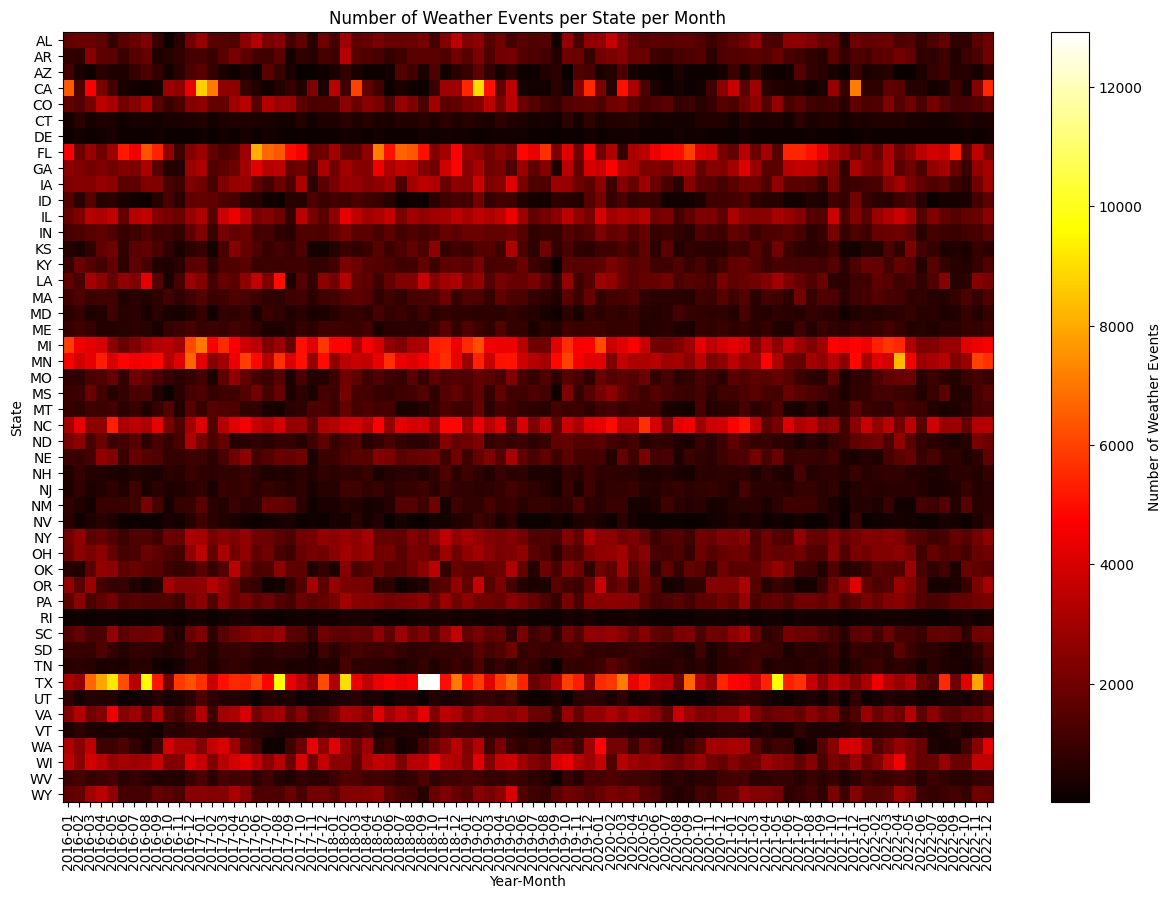

In [115]:
# heatmap with states on the y axis and time on the x axis (year-month) showing number of weather events per state per month
# unsing only we_df
we_df['year_month'] = we_df['StartTime(UTC)'].dt.to_period('M')
disaster_counts = we_df.groupby(['State', 'year_month']).size().unstack(fill_value=0)
plt.figure(figsize=(15,10))
plt.imshow(disaster_counts, aspect='auto', cmap='hot')
plt.colorbar(label='Number of Weather Events')
plt.yticks(ticks=np.arange(len(disaster_counts.index)), labels=disaster_counts.index)
plt.xticks(ticks=np.arange(len(disaster_counts.columns)), labels=disaster_counts.columns.astype(str), rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('State')
plt.title('Number of Weather Events per State per Month')
plt.show()


### Combine the datasets

In [116]:
# make a dataset having one data point per day, per state, with the number of weather events and number of disasters that happened that day in that state
date_range = pd.date_range(start='2016-01-01', end='2022-12-31', freq='D')
states = di_df['state'].unique()
multi_index = pd.MultiIndex.from_product([states, date_range], names=['state', 'date'])
combined_df = pd.DataFrame(index=multi_index).reset_index()

# Prepare date columns
di_df['date'] = di_df['incident_begin_date'].dt.date
we_df['date'] = we_df['StartTime(UTC)'].dt.date

# Aggregate disaster and weather event counts
disaster_counts = di_df.groupby(['state', 'date']).size().reset_index(name='num_disasters')
weather_event_counts = we_df.groupby(['State', 'date']).size().reset_index(name='num_weather_events')
weather_event_counts = weather_event_counts.rename(columns={'State': 'state'})

# Merge counts into combined_df
combined_df['date'] = pd.to_datetime(combined_df['date']).dt.date
combined_df = combined_df.merge(disaster_counts, on=['state', 'date'], how='left')
combined_df = combined_df.merge(weather_event_counts, on=['state', 'date'], how='left')

# Fill NaNs with 0
combined_df['num_disasters'] = combined_df['num_disasters'].fillna(0).astype(int)
combined_df['num_weather_events'] = combined_df['num_weather_events'].fillna(0).astype(int)

combined_df.head()

,state,date,num_disasters,num_weather_events
0,LA,2016-01-01,0,116
1,LA,2016-01-02,0,27
2,LA,2016-01-03,0,76
3,LA,2016-01-04,0,0
4,LA,2016-01-05,0,3


In [117]:
combined_df['y'] = combined_df['num_disasters'] > 0
combined_df.head()

,state,date,num_disasters,num_weather_events,y
0,LA,2016-01-01,0,116,False
1,LA,2016-01-02,0,27,False
2,LA,2016-01-03,0,76,False
3,LA,2016-01-04,0,0,False
4,LA,2016-01-05,0,3,False


In [118]:
combined_df.to_csv('US_disaster_weather_combined.csv', index=False)

#### Visualiztions

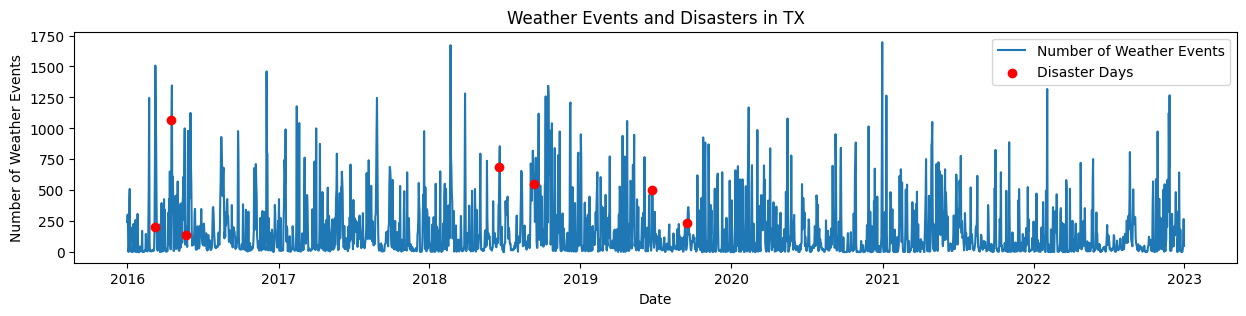

In [119]:
# plot a the combined_df for one state as a time series, with on the y the number of weather events 
# and highlighting every day with a number of sisasters > 0 as an anoamaly
state_to_plot = 'TX'
state_df = combined_df[combined_df['state'] == state_to_plot]
plt.figure(figsize=(15,3))
plt.plot(state_df['date'], state_df['num_weather_events'], label='Number of Weather Events')
anomaly_dates = state_df[state_df['num_disasters'] > 0]['date']
plt.scatter(anomaly_dates, state_df[state_df['num_disasters'] > 0]['num_weather_events'], color='red', label='Disaster Days', zorder=5)
plt.xlabel('Date')
plt.ylabel('Number of Weather Events')
plt.title(f'Weather Events and Disasters in {state_to_plot}')
plt.legend()
plt.show()

## Anomaly detection

### Feature extraction

In [120]:
dataset = combined_df.drop(columns=['num_disasters'])
dataset.rename(columns={'num_weather_events': 'x'}, inplace=True)
dataset.head()

,state,date,x,y
0,LA,2016-01-01,116,False
1,LA,2016-01-02,27,False
2,LA,2016-01-03,76,False
3,LA,2016-01-04,0,False
4,LA,2016-01-05,3,False


In [121]:
# Add lag features for x (num_disasters > 0) per state
lags = [1, 7, 14, 30]
for lag in lags:
    dataset[f'x_lag_{lag}'] = dataset.groupby('state')['x'].shift(lag)

dataset.head()

,state,date,x,y,x_lag_1,x_lag_7,x_lag_14,x_lag_30
0,LA,2016-01-01,116,False,NaN,NaN,NaN,NaN
1,LA,2016-01-02,27,False,116.0,NaN,NaN,NaN
2,LA,2016-01-03,76,False,27.0,NaN,NaN,NaN
3,LA,2016-01-04,0,False,76.0,NaN,NaN,NaN
4,LA,2016-01-05,3,False,0.0,NaN,NaN,NaN


In [122]:
# Add rolling statistics (mean, std) for 7 and 30 days for x, per state
for window in [7, 30]:
    dataset[f'x_roll_mean_{window}'] = dataset.groupby('state')['x'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    dataset[f'x_roll_std_{window}'] = dataset.groupby('state')['x'].transform(lambda x: x.rolling(window, min_periods=1).std())

dataset.head()

,state,date,x,y,x_lag_1,x_lag_7,x_lag_14,x_lag_30,x_roll_mean_7,x_roll_std_7,x_roll_mean_30,x_roll_std_30
0,LA,2016-01-01,116,False,NaN,NaN,NaN,NaN,116.00,NaN,116.00,NaN
1,LA,2016-01-02,27,False,116.0,NaN,NaN,NaN,71.50,62.932504,71.50,62.932504
2,LA,2016-01-03,76,False,27.0,NaN,NaN,NaN,73.00,44.575778,73.00,44.575778
3,LA,2016-01-04,0,False,76.0,NaN,NaN,NaN,54.75,51.545288,54.75,51.545288
4,LA,2016-01-05,3,False,0.0,NaN,NaN,NaN,44.40,50.282204,44.40,50.282204


In [123]:
# Add seasonality features: day of week, week of year (sin/cos)
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['day_of_week'] = dataset['date'].dt.dayofweek
dataset['week_of_year'] = dataset['date'].dt.isocalendar().week
# Encode week of year as sin/cos for cyclicality
dataset['week_of_year_sin'] = np.sin(2 * np.pi * dataset['week_of_year'] / 52)
dataset['week_of_year_cos'] = np.cos(2 * np.pi * dataset['week_of_year'] / 52)

dataset.head()

,state,date,x,y,x_lag_1,x_lag_7,x_lag_14,x_lag_30,x_roll_mean_7,x_roll_std_7,x_roll_mean_30,x_roll_std_30,day_of_week,week_of_year,week_of_year_sin,week_of_year_cos
0,LA,2016-01-01,116,False,NaN,NaN,NaN,NaN,116.00,NaN,116.00,NaN,4,53,0.120537,0.992709
1,LA,2016-01-02,27,False,116.0,NaN,NaN,NaN,71.50,62.932504,71.50,62.932504,5,53,0.120537,0.992709
2,LA,2016-01-03,76,False,27.0,NaN,NaN,NaN,73.00,44.575778,73.00,44.575778,6,53,0.120537,0.992709
3,LA,2016-01-04,0,False,76.0,NaN,NaN,NaN,54.75,51.545288,54.75,51.545288,0,1,0.120537,0.992709
4,LA,2016-01-05,3,False,0.0,NaN,NaN,NaN,44.40,50.282204,44.40,50.282204,1,1,0.120537,0.992709


In [124]:
# Add trend features: rolling z-score and deviation from seasonal average
# Rolling z-score (30-day window)
def rolling_zscore(x, window=30):
    return (x - x.rolling(window, min_periods=1).mean()) / x.rolling(window, min_periods=1).std()
dataset['x_rolling_zscore_30'] = dataset.groupby('state')['x'].transform(lambda x: rolling_zscore(x, 30))

# Deviation from seasonal (day of week) average
dow_avg = dataset.groupby(['state', 'day_of_week'])['x'].transform('mean')
dataset['x_seasonal_deviation'] = dataset['x'] - dow_avg
dataset.head()

,state,date,x,y,x_lag_1,x_lag_7,x_lag_14,x_lag_30,x_roll_mean_7,x_roll_std_7,x_roll_mean_30,x_roll_std_30,day_of_week,week_of_year,week_of_year_sin,week_of_year_cos,x_rolling_zscore_30,x_seasonal_deviation
0,LA,2016-01-01,116,False,NaN,NaN,NaN,NaN,116.00,NaN,116.00,NaN,4,53,0.120537,0.992709,NaN,60.311475
1,LA,2016-01-02,27,False,116.0,NaN,NaN,NaN,71.50,62.932504,71.50,62.932504,5,53,0.120537,0.992709,-0.707107,-39.232240
2,LA,2016-01-03,76,False,27.0,NaN,NaN,NaN,73.00,44.575778,73.00,44.575778,6,53,0.120537,0.992709,0.067301,15.676712
3,LA,2016-01-04,0,False,76.0,NaN,NaN,NaN,54.75,51.545288,54.75,51.545288,0,1,0.120537,0.992709,-1.062173,-61.627397
4,LA,2016-01-05,3,False,0.0,NaN,NaN,NaN,44.40,50.282204,44.40,50.282204,1,1,0.120537,0.992709,-0.823353,-61.917808


### Training

In [125]:
# Split data into train and test, keeping states in the same split
from sklearn.model_selection import train_test_split

states = dataset['state'].unique()
train_states, test_states = train_test_split(states, test_size=0.2, random_state=42)
train_df = dataset[dataset['state'].isin(train_states)].copy()
test_df = dataset[dataset['state'].isin(test_states)].copy()

print('Train states:', train_states)
print('Test states:', test_states)
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train states: ['MT' 'WY' 'MN' 'ND' 'ID' 'OR' 'PA' 'KY' 'LA' 'VT' 'MD' 'UT' 'TX' 'NE'
 'IN' 'MS' 'VA' 'PR' 'WV' 'IL' 'MI' 'SD' 'CA' 'HI' 'NM' 'OH' 'WI' 'MO'
 'TN']
Test states: ['NY' 'WA' 'OK' 'AR' 'NH' 'AZ' 'IA' 'AK']
Train shape: (74153, 18)
Test shape: (20456, 18)


In [144]:
# Build anomaly detector with XGBoost
import xgboost as xgb
from sklearn.metrics import classification_report

# Select features (exclude columns not for training)
feature_cols = [
    col for col in train_df.columns 
    if col not in ['state', 'date', 'y', 'num_disasters', 'num_weather_events']
]

# Ensure all features are numeric (convert lag columns to int)
for col in feature_cols:
    if train_df[col].dtype == 'object':
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

X_train = train_df[feature_cols].fillna(0)
y_train = train_df['y']
X_test = test_df[feature_cols].fillna(0)
y_test = test_df['y']

ratio = (y_train == 0).sum() / (y_train == 1).sum()
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=ratio  # Add this line
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:24:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

       False       1.00      0.98      0.99     20435
        True       0.00      0.05      0.00        21

    accuracy                           0.98     20456
   macro avg       0.50      0.51      0.50     20456
weighted avg       1.00      0.98      0.99     20456



#### Visualization

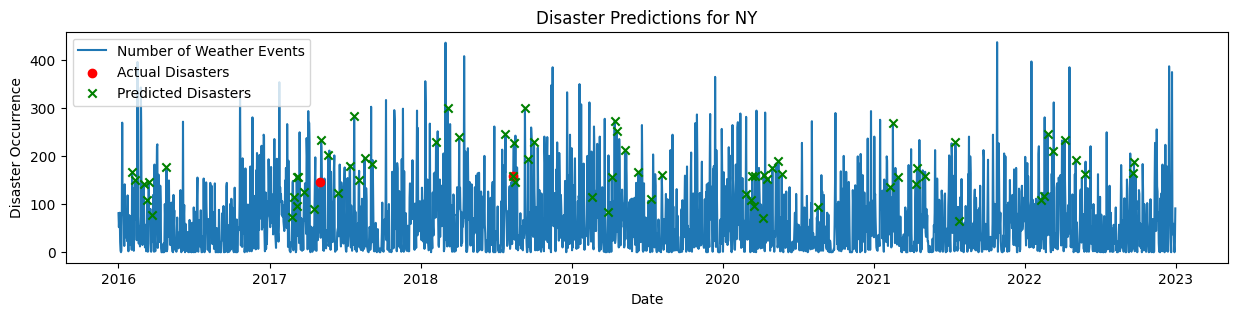

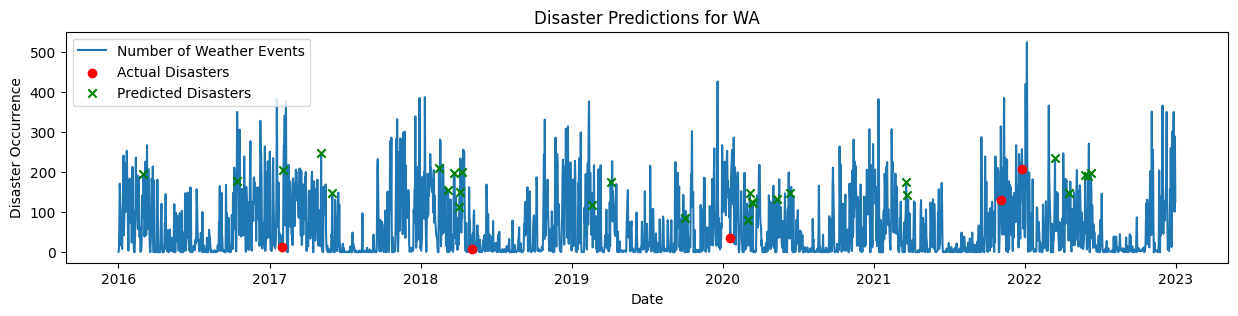

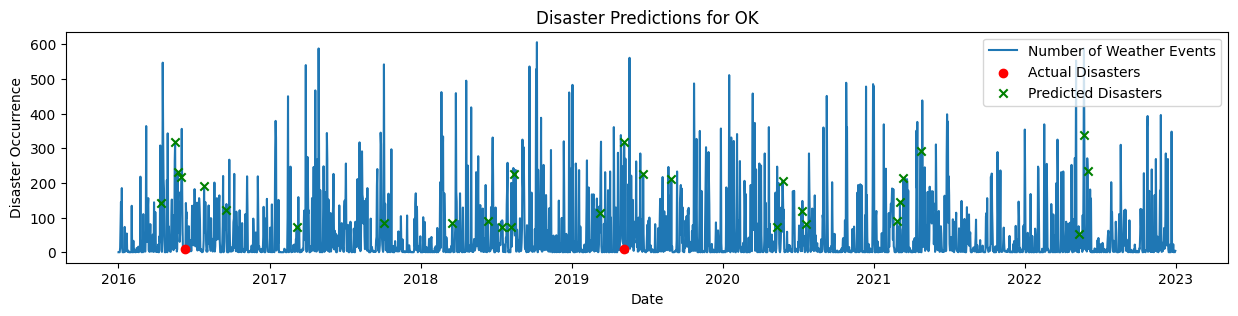

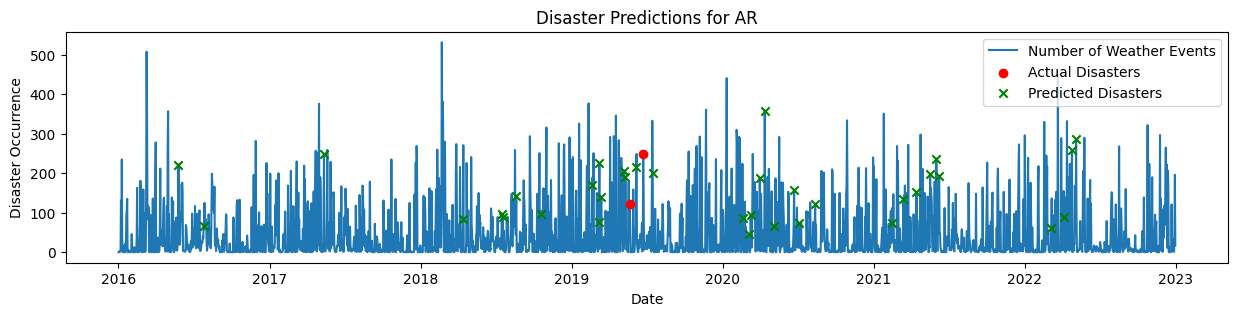

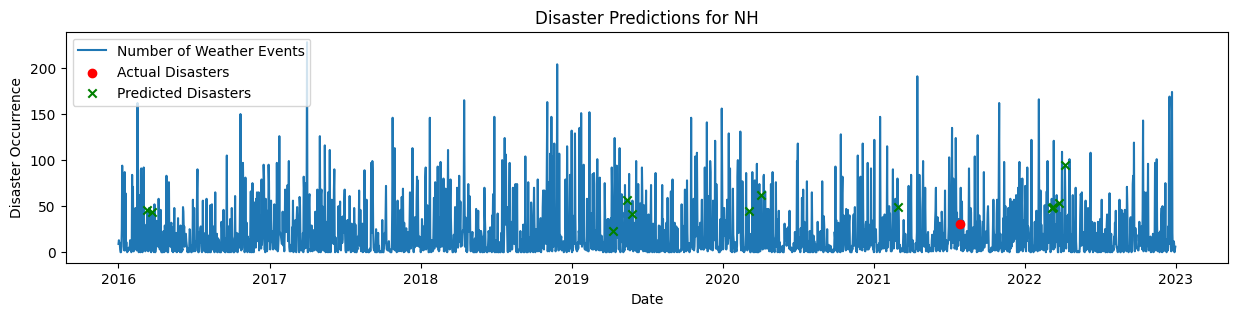

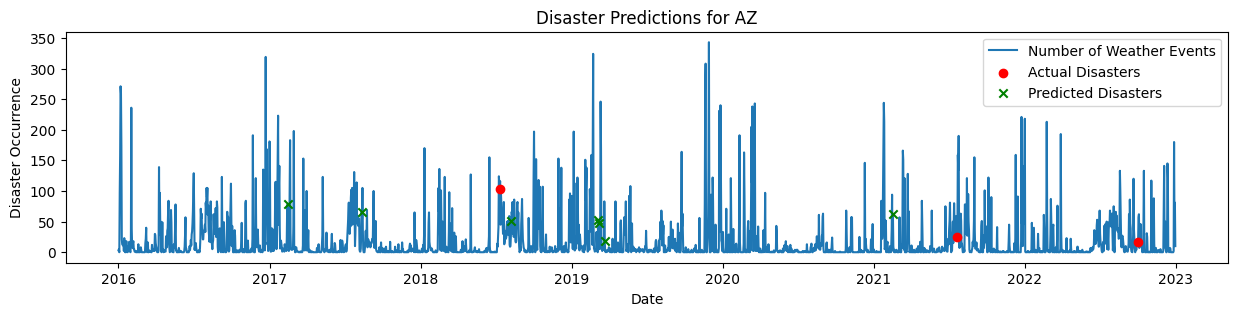

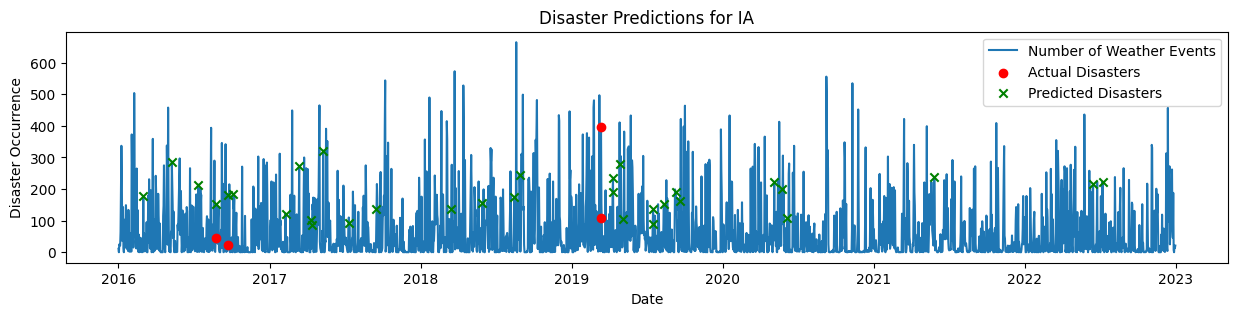

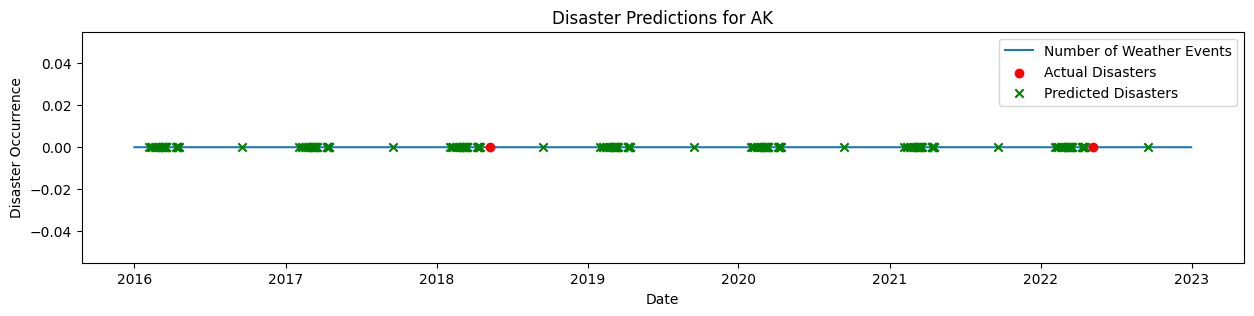

In [ ]:
show_n = 10
for state_to_plot in test_states[:show_n]:
    state_df = test_df[test_df['state'] == state_to_plot].copy()
    plt.figure(figsize=(15,3))
    plt.plot(state_df['date'], state_df['x'], label='Number of Weather Events')
    disaster_days = state_df[state_df['y'] == 1]['date']
    plt.scatter(disaster_days, state_df[state_df['y'] == 1]['x'], color='red', label='Actual Disasters', zorder=5)
    predicted_disaster_days = state_df[model.predict(state_df[feature_cols].fillna(0)) == 1]['date']
    plt.scatter(predicted_disaster_days, state_df[model.predict(state_df[feature_cols].fillna(0)) == 1]['x'], color='green', label='Predicted Disasters', marker='x', zorder=6)
    plt.xlabel('Date')
    plt.ylabel('Disaster Occurrence')
    plt.title(f'Disaster Predictions for {state_to_plot}')
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

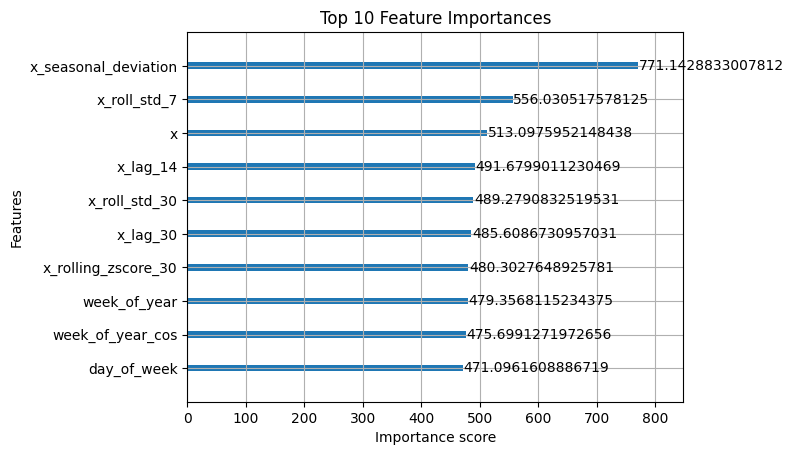

In [136]:
# visualize feature importance
plt.figure(figsize=(10,6))
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importances')
plt.show()